# Forecasting Injections With Prophet
- __My last model used Exponential Smoothing to forecast the number of injections per day for the medical clinic that I work at, now I am going to use Facebook's Prophet library to forecast and compare the models__

In [1]:
import os
import numpy.random as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 5000)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly_express as px

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#displaying numbers instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#modeling
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn_pandas import DataFrameMapper
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults, AR
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

#stationarity assumption
from statsmodels.tsa.stattools import adfuller

#normal assumption
from scipy import stats

#trend analysis
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose

#deep learning for time series modeling
# import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.preprocessing.sequence import TimeseriesGenerator

#prophet forecasting
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [2]:
#import data from EWMA without outliers
df = pd.read_csv('injection_forecast_without_outliers.csv')

## Data Transformation
- __Prophet requires that the columns in the data be 1) a date or timestamp with the column label of 'ds' and 2) the actual data for the time series labeled as 'y'__
- __Without renaming these columns the model will not run__
- __Additionally, the data should only have 2 columns, you may add in extra regressors as well, but in a basic model there should only be the two__

In [3]:
df.head()

,date,number_of_injections,trend
0,2012-09-04,152,154.35
1,2012-09-05,149,153.53
2,2012-09-06,150,152.72
3,2012-09-07,201,151.89
4,2012-09-10,144,151.06


In [5]:
#rename columns and drop trend
df = df[['date', 'number_of_injections']]
df.columns = ['ds', 'y']

In [42]:
#make sure that the columns are correct
df.head()

,ds,y
0,2012-09-04,152
1,2012-09-05,149
2,2012-09-06,150
3,2012-09-07,201
4,2012-09-10,144


## Creating A Baseline Forecast
- __I am going to be intantiating a model and creating a baseline forecast for the data, with a period of 5 days into the future__
- __Forecasts come with a prediction as well as a 95% confidence interval for the prediction__

In [54]:
#instantiate the model
m = Prophet(changepoint_prior_scale=0.01).fit(df)

#creating future dataframe to predict with, adding 5 days to the future dataframe 
future = m.make_future_dataframe(periods=7)

#cutting out weekends from future data, since we dont have data for weekends
future = future[future['ds'].dt.dayofweek < 5]

#making forecast
forecast = m.predict(future)

#looking at forecast, it appears as though we have CIs of about + or - 28
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1763,2020-01-03,248.99,222.41,276.49
1764,2020-01-06,202.73,177.09,230.54
1765,2020-01-07,196.86,170.54,225.37
1766,2020-01-08,203.59,175.83,229.65
1767,2020-01-09,209.66,183.71,237.51


## Visualize Predictions With Previous Data
- __Here I want to see if the predictions are acting as an extension of the previous data's trend components to see if the model seems to be predicting reasonable values__
- __Predicted values are the final piece of the line where there are no residual dots__

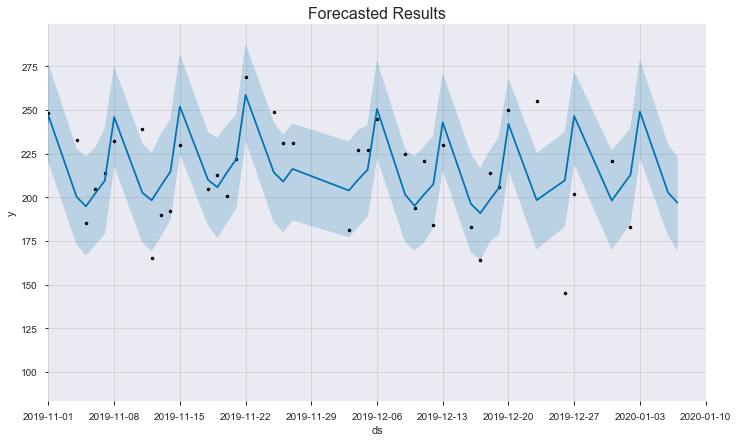

In [50]:
#change datetime to object for plotting
forecast['ds'] = forecast['ds'].astype('object')

#since conversion to object didn't work, I had to use this code to ignore the datetime aspect: 
# https://stackoverflow.com/questions/43206554/typeerror-float-argument-must-be-a-string-or-a-number-not-period
pd.plotting.register_matplotlib_converters()

#visualize forecast
forecast_plot = m.plot(forecast)
plt.xlim('2019-11-01', '2020-01-10')
plt.title('Forecasted Results', fontsize = 16);

## Trend and Seasonality
- __Prophet comes with a great built-in ETS decomposition function that plots the 'components' of the data__
- __Components are broken down into overall trend, weekly trend, and yearly trend__
    - Here the plots are suggesting a clear linear trend overall, with a weekly trend growing steadily and peaking on Friday
    - Lastly, and perhaps most interesting to me, is the seasonal look, which indicates several peaks throughout the year. Primarily, the injections peak in the spring, with two more peaks in June and August, followed by a peak in the early fall, followed by one final peak in the latter part of November, culminating in a sharp decline until March

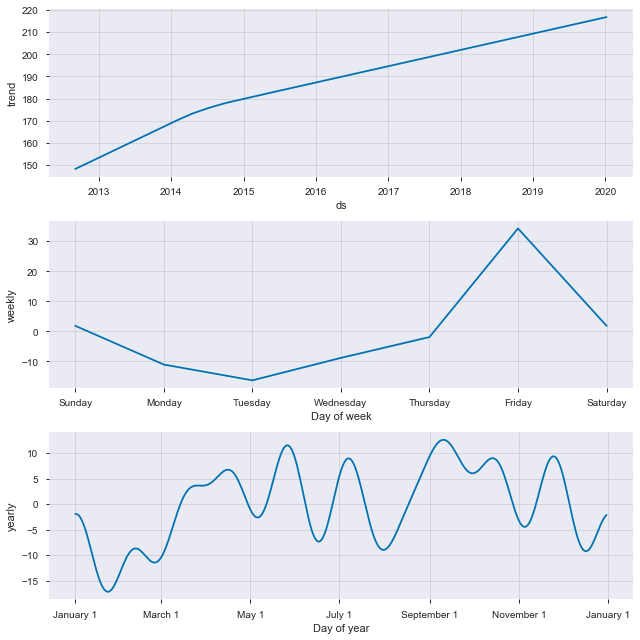

In [40]:
#plot components
components_plot = m.plot_components(forecast)